In [ ]:
# 20_deep_learning_hybrid_emnist.ipynb, deep learning hybrid(CNN + RNN) model overview

# 딥러닝 하이브리드 모델 개요
# 1. 하이브리드 구조 개념
# - CNN (Convolutional Neural Network): 이미지나 공간적 데이터를 처리하여 특징(feature)을 추출합니다.
# - RNN (Recurrent Neural Network) 또는 LSTM/GRU: 시계열적 특성을 가진 데이터를 처리하거나 CNN이 추출한 특징을 시퀀스로 간주해 순차적으로 처리합니다.

# 2. 대표적인 활용 예
# - 이미지 캡셔닝: CNN으로 이미지 특징 추출 → RNN으로 문장 생성
# - 비디오 분석: 프레임별 CNN 처리 → RNN으로 시간적 흐름 분석
# - 필기 인식: 이미지 → CNN → RNN → 텍스트 출력

# 3. 전체 로드맵 요약
# - 1단계 EMNIST : 목표(문자 분류), 모델 구조(CNN + RNN)
# - 2단계 IAM Handwriting : 목표(문자 예측), 모델 구조(CNN + RNN + CTC)
# - 3단계 UCF101 : 목표(액션 분류), 모델 구조(CNN + RNN)
# - 4단계 COCO Captions : 목표(이미지 캡셔닝), 모델 구조(CNN + RNN(텍스트 생성))

# 4. 대표적인 활용 데이터 셋 설명
# 1단계: EMNIST (문자 인식)
# - 데이터: 손글씨 알파벳 + 숫자 이미지
# - 목표: 단일 문자 분류
# - 모델 구조: CNN → RNN → Softmax 분류
# - 포인트:
# -   MNIST와 유사한 구조로 쉽게 확장 가능å
# -   다양한 클래스(숫자 + 알파벳)로 분류 성능 향상 실험 가능

# 2단계: IAM Handwriting (문장 인식)
# - 데이터: 실제 손글씨 문장 이미지 + 텍스트 라벨
# - 목표: 이미지 → 시퀀스 텍스트 예측
# - 모델 구조: CNN → RNN → CTC Loss 기반 시퀀스 예측
# - 포인트:
# -   CTC (Connectionist Temporal Classification) 사용
# -   OCR 기반 모델 설계 경험 가능
# -   전처리 중요: 이미지 정규화, 라벨 토큰화

# 3단계: UCF101 (비디오 액션 분류)
# - 데이터: 101가지 액션이 담긴 짧은 비디오 클립
# - 목표: 비디오 → 액션 분류
# - 모델 구조: CNN (프레임별) → RNN (시간 흐름) → 분류
# - 포인트:
# -   프레임 추출 + CNN 처리 → 시퀀스 입력
# -   Temporal dynamics 학습
# -   3D CNN 또는 2D CNN + RNN 조합 실험 가능

# 4단계: COCO Captions (이미지 캡셔닝)
# - 데이터: 이미지 + 캡션 텍스트
# - 목표: 이미지 → 문장 생성
# - 모델 구조: CNN → RNN (LSTM/GRU) → 텍스트 생성
# - 포인트:
# -   멀티모달 학습 경험
# -   BLEU, CIDEr 등 캡셔닝 평가 지표 활용
# -   Attention 메커니즘 추가 가능

# 5. 단일 모델과 하이브리드 모델의 핵심 차이점 설명
# - CNN vs CNN + RNN: 핵심 차이점
# ------------|-------------------------------------------|-----------------------------------------------------------------
# 항목        | CNN 단독 모델                               | CNN + RNN 하이브리드 모델
# ------------|-------------------------------------------|-----------------------------------------------------------------
# 목적        | 공간적 특징 추출 및 분류                     | 공간 + 시간/순차적 특징 처리
# 입력 데이터  | 단일 이미지                                 | 이미지 시퀀스, 영상, 시계열
# 처리 방식    | 이미지->특징->분류                          | 이미지->CNN특징->RNN시퀀스 처리
# 구조        | Conv->Pool->FC->Softmax                   | Conv->Pool->RNN->FC->Softmax
# 기억 능력    | 없음(독립적 처리)                           | 있음(이전 정보 기억 가능)
# 적용 분야    | 이미지 분류, 객체 탐지                       | 영상 분석, 이미지 캡셔닝,OCR, 행동 예측
# 예시        | 입력: 고양이 사진 1장                        | 입력: 고양이가 움직이는 영상(프레임 시퀀스)
#             | 처리: CNN이 공간적 특징 추출->’고양이’로 분류  | 처리: 각 프레임 CNN처리->RNN이 시간 흐름 분석->’고양이 점프 중’으로 분류
# ------------|-------------------------------------------|-----------------------------------------------------------------


In [1]:
# 1) 라이브러리, GPU 설정
import torch
from torch import nn
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from datetime import datetime
import os
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Pytorch Version:{torch.__version__}, device: {DEVICE}')

Using Pytorch Version:2.7.1+cu118, device: cuda


In [2]:
# 2) 전처리 및 데이터셋 로드
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.EMNIST(
    root='./data/emnist',
    split='balanced', # 'balanced', 'letters', 'digits', 'byclass', 'bymerge' 중 선택
    train=True,
    transform=transform_train,
    download=True
)

test_dataset = datasets.EMNIST(
    root='./data/emnist',
    split='balanced',
    train=False,
    transform=transform_test,
    download=True
)

In [3]:
# 3) 데이터셋 분리 - train : validation = 8:2
train_dataset_size = int(0.8 * len(train_dataset))
validation_dataset_size = len(train_dataset) - train_dataset_size
train_dataset, validation_dataset = random_split(
    dataset=train_dataset, 
    lengths=[train_dataset_size, validation_dataset_size],
    generator=torch.Generator().manual_seed(42) # 재현 가능한 결과 - 난수 시드를 고정해줘야 동일한 결과가 나옴
    )

In [4]:
# 데이터 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))  # 48000 12000 10000

90240 22560 18800


In [5]:
# 4) Batch, DataLoader 설정
import multiprocessing
BATCH_SIZE = 16
num_workers = multiprocessing.cpu_count() // 2

train_dataset_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

validation_dataset_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_dataset_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

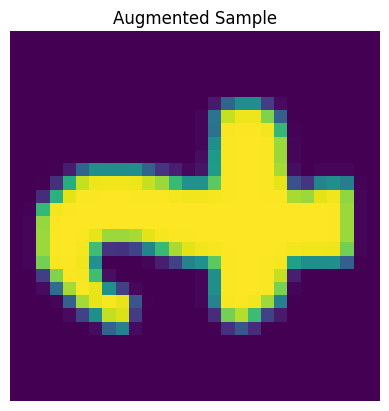

In [6]:
import matplotlib.pyplot as plt

sample = train_dataset[0][0]  # 이미지 텐서
plt.imshow(sample.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
plt.title("Augmented Sample")
plt.axis('off')
plt.show()

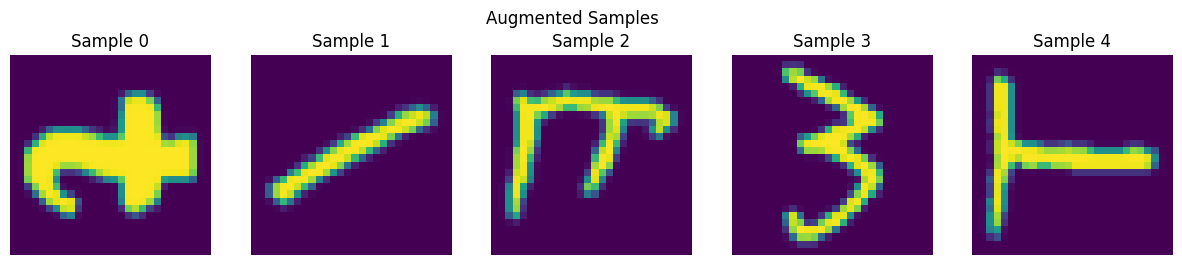

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    sample = train_dataset[i][0]
    axes[i].imshow(sample.permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f"Sample {i}")
plt.suptitle("Augmented Samples")
plt.show()

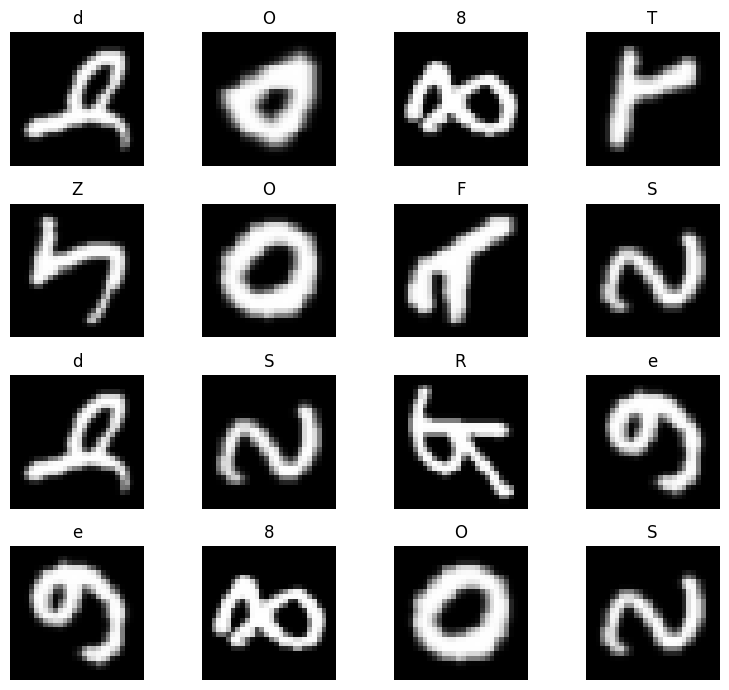

In [8]:
# 5) 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    # - torch.randint()는 0부터 high - 1 사이의 정수를 생성
    # - len(images)는 현재 배치에 포함된 이미지 수예요. 예를 들어 BATCH_SIZE = 32이면 len(images)는 32
    # - size = (1,) 생성할 정수의 **개수와 형태(shape)**를 지정, (1,)은 1개의 정수를 담은 1차원 텐서를 의미, 예시: tensor([17]) 결과
    sample_idx = torch.randint(len(images), size=(1, )).item() # 0~31 사이의 정수 중 하나를 랜덤하게 생성
    img, label = images[sample_idx], labels[sample_idx].item() # - 이미지와 라벨 추출

    # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    # img = img * std + mean # 정규화된 이미지 복원
    
    plt.subplot(rows, cols, i)
    # plt.imshow(torch.permute(img, (1, 2, 0))) # (C, H, W) -> (H, W, C) 순서 변경
    plt.imshow(img.squeeze(), cmap='gray') # 흑백 이미지 표시
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# 6) 하이브리드 모델 설계 - CNN → RNN 조합으로 이미지 내 시퀀스적 패턴 학습 가능
class HybridModel_CNN_RNN(nn.Module): # 입력: (B, 1, 28, 28) — MNIST 흑백 이미지
    def __init__(self, in_channels=1, rnn_hidden=128, num_classes=47, dropout_rate=0.3):
        super(HybridModel_CNN_RNN, self).__init__()

        # CNN 부분
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1), # (B, 32, 28, 28)
            nn.ReLU(), # 비선형성 확보
            nn.MaxPool2d(kernel_size=2, stride=2), # (B, 32, 14, 14)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (B, 64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (B, 64, 7, 7)

            nn.Dropout(dropout_rate) # 과적합 방지
        )
        
        # RNN 부분: CNN 출력 feature map을 시퀀스로 변환
        self.rnn_input_size = 64 # feature dimension
        self.rnn_seq_len = 7 * 7 # 시퀀스 길이
        self.rnn = nn.LSTM(
            input_size=self.rnn_input_size, # 입력: (B, 49, 64)
            hidden_size=rnn_hidden, # 출력: (B, 49, 128)
            num_layers=2, # 2-layer LSTM으로 깊은 시퀀스 학습
            dropout=dropout_rate, # 과적합 방지
            batch_first=True,
            bidirectional=True # 양방향 LSTM 설정 - 앞뒤로 학습하게 되어 풍부한 문맥 정보를 얻을수 있으며, LSTM의 출력 차원이 2배로 증가
        )
        
        # 최종 분류기
        self.fc = nn.Sequential(
            nn.Linear(rnn_hidden * 2, 64), # LSTM 출력(128 X 2) = 256 -> 64 차원으로 축소, bidirectional=True 양방향 설정으로 2배 증가

            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes) # 47개 클래스 분류
        )
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN 통과 - 2개의 Conv + ReLU + MaxPool 블록으로 28×28 → 7×7로 다운샘플링
        x = self.cnn(x)  # (batch_size, 64, 7, 7)

        # CNN 출력 -> 시퀀스 형태로 변환
        x = x.permute(0, 2, 3, 1).contiguous()  # (batch_size, 7, 7, 64), 안전하게 메모리 연속성 확보
        x = x.view(batch_size, self.rnn_seq_len, self.rnn_input_size) # (batch_size, seq_len=49, features=64)
        
        # RNN 통과 - CNN 출력(64×7×7)을 flatten 후 LSTM에 시퀀스 길이 1로 입력
        x, _ = self.rnn(x) # (batch_size, seq_len=49, rnn_hidden=256)
        x = x[:, -1, :]  # 마지막 시퀀스 출력 사용 (batch_size, rnn_hidden=256)
        
        # 최종 분류 - LSTM의 마지막 hidden state를 받아 47개 클래스 분류
        x = self.fc(x) # (batch_size, num_classes=47)
        return x

In [10]:
# 7) EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='./models/model_hybrid_emnist.pt'):
        self.patience = patience          # 개선되지 않아도 기다릴 epoch 수
        self.verbose = verbose            # 개선 시 출력 여부
        self.counter = 0                  # 개선되지 않은 epoch 수
        self.best_score = None            # 최고 성능 점수
        self.early_stop = False           # 중단 여부
        self.val_loss_min = float('inf')  # 최소 validation loss
        self.delta = delta                # 개선 최소 차이
        self.path = path                  # 모델 저장 경로

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Validation loss가 감소하면 모델 저장'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [11]:
# 8) model, loss, optimizer 객체 생성
#  Model 객체 생성
model = HybridModel_CNN_RNN(in_channels=1, rnn_hidden=128, num_classes=47).to(DEVICE)
# loss function
loss_function = nn.CrossEntropyLoss() # Softmax() 함수 포함되어 있음
# optimizer, weight_decay=1e-5 추가하여 가중치 감쇠(L2 정규화) 적용(모델의 일반화 성능을 높이고 과적합을 방지하는 데 도움)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# Model 정보
print(model)

HybridModel_CNN_RNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.3, inplace=False)
  )
  (rnn): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=47, bias=True)
  )
)


In [12]:
# 9) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0 # train loss 합
    train_correct = 0 # train 맞춘 개수
    train_total = 0 # train 전체 개수
    total_train_batch = len(dataloader) # 전체 배치 개수
    for images, labels in dataloader: # dataloader에서 배치 단위로 이미지와 라벨 추출        
        x_train = images.to(DEVICE) # GPU로 데이터 전송
        y_train = labels.to(DEVICE)
        
        outputs = model(x_train) # 모델 예측
        loss = loss_function(outputs, y_train) # 손실함수 계산

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item() # 오차 누적
        train_total += y_train.size(0) # 배치 내 샘플 개수 누적
        train_correct += (torch.argmax(outputs, dim=1) == y_train).sum().item() # - argmax로 예측값과 실제값 비교 후 맞춘 개수 누적
        
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [13]:
# 10) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)
        for images, labels in dataloader:            
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, dim=1) == y_val).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [14]:
# 11) Model test 함수
def model_test(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)
        for images, labels in dataloader:            
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, dim=1) == y_test).sum().item()
            
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)
        return test_avg_loss, test_avg_accuracy


In [15]:
# 12) Confusion Matrix(혼동행렬) 시각화 함수
def confusion_matrix_plot(dataloader, model):
    model.eval() # 추론모드
    all_labels = []
    all_preds = []
    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test) # 모델 추론
            _, preds = torch.max(outputs, 1) # 모델 예측값 추출

            all_labels.extend(y_test.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
            all_preds.extend(preds.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
    
    cm = confusion_matrix(all_labels, all_preds) # 혼동행렬(Confusion Matrix) 계산
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[labels_map[i] for i in range(len(labels_map))]) # - display_labels에 클래스 이름 전달
    plt.figure(figsize=(8, 6)) # - 그래프 크기 설정
    disp.plot(cmap=plt.cm.Blues) # - 블루 계열의 컬러맵 사용
    plt.xticks(rotation=45) # x축 라벨 45도 회전
    plt.title('Confusion Matrix') # - 타이틀 추가
    plt.show()

In [16]:
# 13) Classification Report 함수
def classification_report_plt(dataloader, model):
    model.eval() # 추론모드
    all_labels = []
    all_preds = []
    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test) # 모델 추론
            _, preds = torch.max(outputs, 1) # 모델 예측값 추출

            all_labels.extend(y_test.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
            all_preds.extend(preds.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
    
    target_names = list(labels_map.values()) # - 클래스 이름 리스트 생성
    report = classification_report(all_labels, all_preds, target_names=target_names, digits=4) # - 분류 리포트 생성, digits=4로 소수점 4자리까지 출력 → 정밀한 비교 가능

    print(report) # - 분류 리포트 출력

In [17]:
# 14) Model 학습 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
start_time = datetime.now()
early_stopping = EarlyStopping(patience=5, verbose=True)
EPOCHS = 30 # cpu 사용시 에폭 3배이상 낮게 설정

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader, model=model, loss_function=loss_function, optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader, model=model, loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # early stopping
    early_stopping(val_loss=val_avg_loss, model=model)
    
    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

Validation loss decreased (inf → 0.802734). Saving model...
epoch :  01 train loss =  1.951630 , train acc =  41.679965 val loss =  0.802734 , val acc =  72.362589
Validation loss decreased (0.802734 → 0.550397). Saving model...
epoch :  02 train loss =  0.810455 , train acc =  73.897385 val loss =  0.550397 , val acc =  81.502660
Validation loss decreased (0.550397 → 0.482273). Saving model...
epoch :  03 train loss =  0.625077 , train acc =  79.413785 val loss =  0.482273 , val acc =  83.368794
Validation loss decreased (0.482273 → 0.436674). Saving model...
epoch :  04 train loss =  0.548744 , train acc =  81.900488 val loss =  0.436674 , val acc =  84.955674
Validation loss decreased (0.436674 → 0.407488). Saving model...
epoch :  05 train loss =  0.502775 , train acc =  83.233599 val loss =  0.407488 , val acc =  86.059397
Validation loss decreased (0.407488 → 0.386766). Saving model...
epoch :  06 train loss =  0.470983 , train acc =  84.227615 val loss =  0.386766 , val acc =  8

In [18]:
# 15) 테스트 데이터셋 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader, model=model, loss_function=loss_function)

accuracy =  88.19148936170212 , loss =  0.35312829286137476


(0.35312829286137476, 88.19148936170212)

<Figure size 800x600 with 0 Axes>

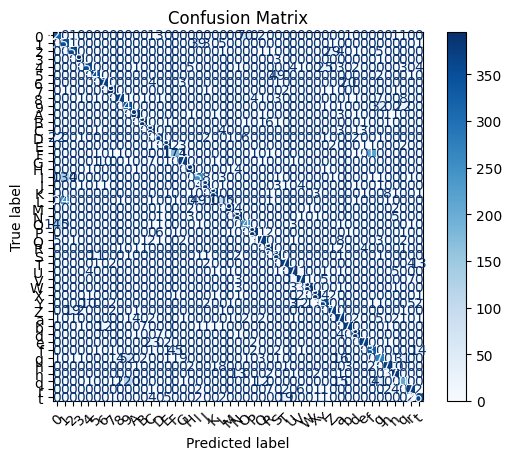

In [19]:
# 16) Confusion Matrix(혼동행렬) 시각화
confusion_matrix_plot(dataloader=test_dataset_loader, model=model)

In [20]:
# 17) clssification report 출력
classification_report_plt(dataloader=test_dataset_loader, model=model)

              precision    recall  f1-score   support

           0     0.6478    0.8000    0.7159       400
           1     0.4828    0.8750    0.6222       400
           2     0.9372    0.8950    0.9156       400
           3     0.9826    0.9900    0.9863       400
           4     0.9538    0.8775    0.9141       400
           5     0.9508    0.8700    0.9086       400
           6     0.9418    0.9300    0.9358       400
           7     0.9728    0.9825    0.9776       400
           8     0.9763    0.9250    0.9499       400
           9     0.6615    0.8600    0.7478       400
           A     0.9751    0.9775    0.9763       400
           B     0.9700    0.9700    0.9700       400
           C     0.8899    0.9700    0.9282       400
           D     0.9455    0.9100    0.9274       400
           E     0.9676    0.9700    0.9688       400
           F     0.7733    0.4350    0.5568       400
           G     0.9496    0.9425    0.9460       400
           H     0.9655    

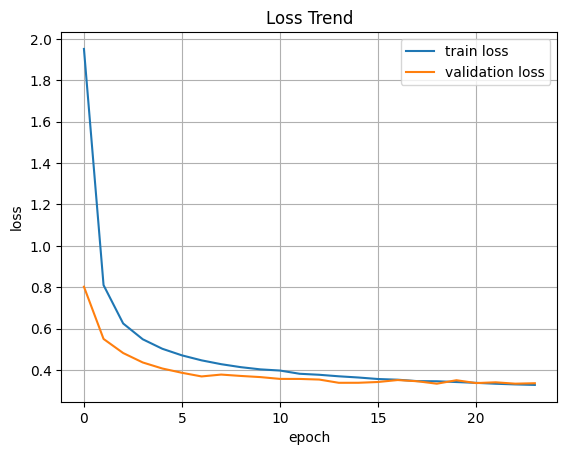

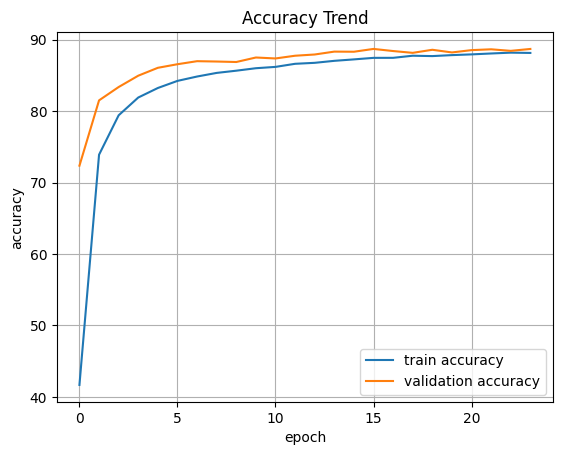

In [21]:
# 18) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [22]:
# 19) Save the model checkpoint
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_hybrid_emnist.pt')

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


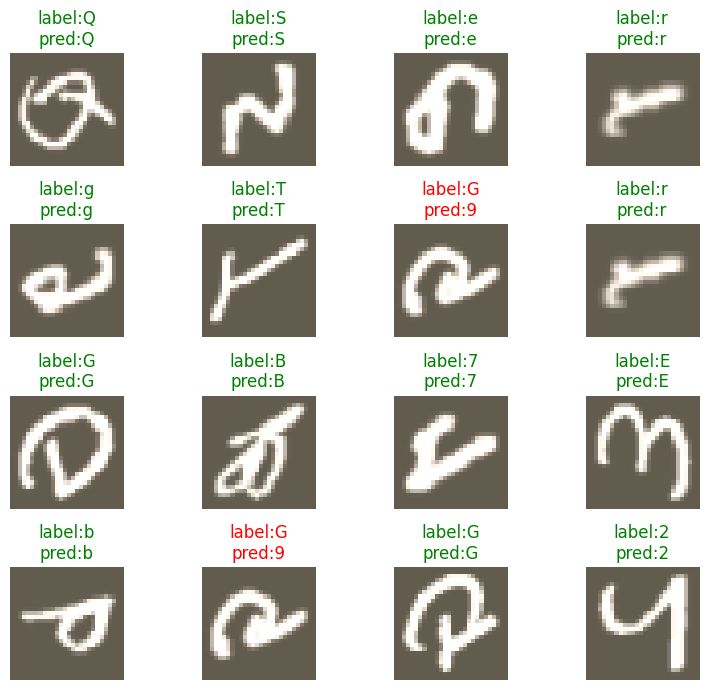

In [23]:
# 20) 테스트 - 모델 추론 및 예측값 추출
BATCH_SIZE = 32

# test dataloaer 생성
test_image_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_images, test_labels = next(iter(test_image_loader)) # 1개 배치 추출

x_test = test_images.to(DEVICE) # - GPU로 데이터 이동
y_test = test_labels.to(DEVICE)

outputs = model(x_test) # 모델 추론
_, preds = torch.max(outputs, 1) # 모델 예측값 추출

# 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    img = img * std + mean # 정규화된 이미지 복원
    img = img.clamp(0, 1) # 0~1 사이의 값으로 클램핑

    correct = (label == pred) # 정답 여부
    title_color = 'green' if correct else 'red' # 정답이면 녹색, 오답이면 빨간색
    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred], color=title_color) # - 정답이면 녹색, 오답이면 빨간색 타이틀 출력
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()